# Word2Vec之Skip-Gram模型

下面代码将用TensorFlow实现Word2Vec中的Skip-Gram模型。

关于Skip-Gram模型请参考上一篇[知乎专栏文章](https://zhuanlan.zhihu.com/p/27234078)

# 1 导入包

In [1]:
import time
import numpy as np
import tensorflow as tf
import random
from collections import Counter

/home/jason/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 2 加载数据

数据集使用的是来自Matt Mahoney的维基百科文章，数据集已经被清洗过，去除了特殊符号等，并不是全量数据，只是部分数据，所以实际上最后训练出的结果很一般（语料不够）。

如果想获取更全的语料数据，可以访问以下网站，这是gensim中Word2Vec提供的语料：

- 来自Matt Mahoney预处理后的[文本子集](http://mattmahoney.net/dc/enwik9.zip)，里面包含了10亿个字符。
- 与第一条一样的经过预处理的[文本数据](http://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2)，但是包含了30个亿的字符。
- 多种语言的[训练文本](http://www.statmt.org/wmt11/translation-task.html#download)。
- [UMBC webbase corpus](http://ebiquity.umbc.edu/redirect/to/resource/id/351/UMBC-webbase-corpus)

In [2]:
with open('data/text8') as f:
    text = f.read()

# 3 数据预处理

数据预处理过程主要包括：

- 替换文本中特殊符号并去除低频词
- 对文本分词
- 构建语料
- 单词映射表

In [3]:
# 定义函数来完成数据的预处理
def preprocess(text, freq=5):
    '''
    对文本进行预处理
    
    参数
    ---
    text: 文本数据
    freq: 词频阈值
    '''
    # 对文本中的符号进行替换
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # 删除低频词，减少噪音影响
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > freq]

    return trimmed_words

In [4]:
# 清洗文本并分词
words = preprocess(text)
print(words[:20])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']


In [5]:
# 构建映射表
vocab = set(words)
vocab_to_int = {w: c for c, w in enumerate(vocab)}
int_to_vocab = {c: w for c, w in enumerate(vocab)}

In [6]:
print("total words: {}".format(len(words)))
print("unique words: {}".format(len(set(words))))

total words: 16680599
unique words: 63641


In [7]:
# 对原文本进行vocab到int的转换
int_words = [vocab_to_int[w] for w in words]

# 4 采样

对停用词进行采样，例如“the”， “of”以及“for”这类单词进行剔除。剔除这些单词以后能够加快我们的训练过程，同时减少训练过程中的噪音。

我们采用以下公式:
$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

其中$ t $是一个阈值参数，一般为1e-3至1e-5。  
$f(w_i)$ 是单词 $w_i$ 在整个数据集中的出现频次。  
$P(w_i)$ 是单词被删除的概率。

>这个公式和论文中描述的那个公式有一些不同

In [8]:
t = 1e-5 # t值
threshold = 0.8 # 剔除概率阈值

# 统计单词出现频次
int_word_counts = Counter(int_words)
total_count = len(int_words)
# 计算单词频率
word_freqs = {w: c/total_count for w, c in int_word_counts.items()}
# 计算被删除的概率
prob_drop = {w: 1 - np.sqrt(t / word_freqs[w]) for w in int_word_counts}
# 对单词进行采样
train_words = [w for w in int_words if prob_drop[w] < threshold]

In [9]:
len(train_words)

6925252

In [10]:
# 从上面数据可以看到，我们本身有1670万的文本，经过采样后剩下693万。

# 5 构造batch

Skip-Gram模型是通过输入词来预测上下文。因此我们要构造我们的训练样本，具体思想请参考知乎专栏，这里不再重复。

对于一个给定词，离它越近的词可能与它越相关，离它越远的词越不相关，这里我们设置窗口大小为5，对于每个训练单词，我们还会在[1:5]之间随机生成一个整数R，用R作为我们最终选择output word的窗口大小。这里之所以多加了一步随机数的窗口重新选择步骤，是为了能够让模型更聚焦于当前input word的邻近词。

In [11]:
def get_targets(words, idx, window_size=5):
    '''
    获得input word的上下文单词列表
    
    参数
    ---
    words: 单词列表
    idx: input word的索引号
    window_size: 窗口大小
    '''
    target_window = np.random.randint(1, window_size+1)
    # 这里要考虑input word前面单词不够的情况
    start_point = idx - target_window if (idx - target_window) > 0 else 0
    end_point = idx + target_window
    # output words(即窗口中的上下文单词)
    targets = set(words[start_point: idx] + words[idx+1: end_point+1])
    return list(targets)

In [12]:
def get_batches(words, batch_size, window_size=5):
    '''
    构造一个获取batch的生成器
    '''
    n_batches = len(words) // batch_size
    
    # 仅取full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx: idx+batch_size]
        for i in range(len(batch)):
            batch_x = batch[i]
            batch_y = get_targets(batch, i, window_size)
            # 由于一个input word会对应多个output word，因此需要长度统一
            x.extend([batch_x]*len(batch_y))
            y.extend(batch_y)
        yield x, y

# 6 构建网络

该部分主要包括：

- 输入层
- Embedding
- Negative Sampling

## 输入

In [13]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, shape=[None], name='inputs')
    labels = tf.placeholder(tf.int32, shape=[None, None], name='labels')

## Embedding

嵌入矩阵的矩阵形状为 $ vocab\_size\times hidden\_units\_size$ 

TensorFlow中的tf.nn.embedding_lookup函数可以实现lookup的计算方式

In [14]:
vocab_size = len(int_to_vocab)
embedding_size = 200 # 嵌入维度

In [15]:
with train_graph.as_default():
    # 嵌入层权重矩阵
    embedding = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1, 1))
    # 实现lookup
    embed = tf.nn.embedding_lookup(embedding, inputs)

Instructions for updating:
Colocations handled automatically by placer.


## Negative Sampling

负采样主要是为了解决梯度下降计算速度慢的问题，详情同样参考我的上一篇知乎专栏文章。

TensorFlow中的tf.nn.sampled_softmax_loss会在softmax层上进行采样计算损失，计算出的loss要比full softmax loss低。

In [16]:
n_sampled = 100

with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal([vocab_size, embedding_size], stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(vocab_size))
    
    # 计算negative sampling下的损失
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, vocab_size)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use tf.cast instead.


## 验证

为了更加直观的看到我们训练的结果，我们将查看训练出的相近语义的词。

In [17]:
with train_graph.as_default():
    # 随机挑选一些单词
    valid_size = 16 
    valid_window = 100
    # 从不同位置各选8个单词
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    
    valid_size = len(valid_examples)
    # 验证单词集
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # 计算每个词向量的模并进行单位化
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    # 查找验证单词的词向量
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    # 计算余弦相似度
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [18]:
epochs = 10 # 迭代轮数
batch_size = 1000 # batch大小
window_size = 10 # 窗口大小

with train_graph.as_default():
    saver = tf.train.Saver() # 文件存储

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        # 
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            # 计算相似的词
            if iteration % 1000 == 0:
                # 计算similarity
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # 取最相似单词的前8个
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to [%s]:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
            
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 3.7088 0.0267 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 3.6744 0.0232 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 3.6422 0.0237 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 3.6138 0.0219 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 3.6001 0.0236 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 3.5631 0.0232 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 3.5246 0.0225 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 3.4922 0.0231 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 3.4115 0.0233 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 3.3433 0.0231 sec/batch
Nearest to [legionaries]: asp, orf, mercenaries, photojournalist, milloy, newstead, haudenosaunee, spurt,
Nearest to [escaped]: llu, secession, widdecombe, tactician, pomp, inequalities, millions, unhindered,
Nearest to [kippur]: nacht, polygyny, frankenchrist, muhsin, subtracted, burman, hog, bres

Epoch 1/10 Iteration: 4100 Avg. Training loss: 2.5704 0.0240 sec/batch
Epoch 1/10 Iteration: 4200 Avg. Training loss: 2.5436 0.0222 sec/batch
Epoch 1/10 Iteration: 4300 Avg. Training loss: 2.5875 0.0218 sec/batch
Epoch 1/10 Iteration: 4400 Avg. Training loss: 2.4957 0.0229 sec/batch
Epoch 1/10 Iteration: 4500 Avg. Training loss: 2.5517 0.0231 sec/batch
Epoch 1/10 Iteration: 4600 Avg. Training loss: 2.5402 0.0228 sec/batch
Epoch 1/10 Iteration: 4700 Avg. Training loss: 2.6100 0.0235 sec/batch
Epoch 1/10 Iteration: 4800 Avg. Training loss: 2.4970 0.0226 sec/batch
Epoch 1/10 Iteration: 4900 Avg. Training loss: 2.4741 0.0230 sec/batch
Epoch 1/10 Iteration: 5000 Avg. Training loss: 2.6281 0.0237 sec/batch
Nearest to [legionaries]: asp, milloy, mercenaries, orf, photojournalist, spurt, haudenosaunee, reunions,
Nearest to [escaped]: secession, widdecombe, llu, tactician, unhindered, pomp, millions, jakobson,
Nearest to [kippur]: polygyny, nacht, frankenchrist, muhsin, burman, subtracted, hog,

Epoch 2/10 Iteration: 8100 Avg. Training loss: 2.2605 0.0229 sec/batch
Epoch 2/10 Iteration: 8200 Avg. Training loss: 2.3611 0.0224 sec/batch
Epoch 2/10 Iteration: 8300 Avg. Training loss: 2.3629 0.0237 sec/batch
Epoch 2/10 Iteration: 8400 Avg. Training loss: 2.2364 0.0232 sec/batch
Epoch 2/10 Iteration: 8500 Avg. Training loss: 2.1652 0.0219 sec/batch
Epoch 2/10 Iteration: 8600 Avg. Training loss: 2.1768 0.0220 sec/batch
Epoch 2/10 Iteration: 8700 Avg. Training loss: 2.1357 0.0215 sec/batch
Epoch 2/10 Iteration: 8800 Avg. Training loss: 2.2411 0.0226 sec/batch
Epoch 2/10 Iteration: 8900 Avg. Training loss: 2.3678 0.0228 sec/batch
Epoch 2/10 Iteration: 9000 Avg. Training loss: 2.3433 0.0232 sec/batch
Nearest to [legionaries]: photojournalist, orf, mercenaries, milloy, asp, spurt, newstead, haudenosaunee,
Nearest to [escaped]: widdecombe, llu, secession, unhindered, tactician, pomp, millions, jakobson,
Nearest to [kippur]: polygyny, nacht, muhsin, frankenchrist, burman, basrah, coase, h

Epoch 2/10 Iteration: 12100 Avg. Training loss: 2.2584 0.0245 sec/batch
Epoch 2/10 Iteration: 12200 Avg. Training loss: 2.2504 0.0215 sec/batch
Epoch 2/10 Iteration: 12300 Avg. Training loss: 2.1545 0.0228 sec/batch
Epoch 2/10 Iteration: 12400 Avg. Training loss: 2.2775 0.0236 sec/batch
Epoch 2/10 Iteration: 12500 Avg. Training loss: 2.2458 0.0228 sec/batch
Epoch 2/10 Iteration: 12600 Avg. Training loss: 2.4082 0.0226 sec/batch
Epoch 2/10 Iteration: 12700 Avg. Training loss: 2.3037 0.0226 sec/batch
Epoch 2/10 Iteration: 12800 Avg. Training loss: 2.0938 0.0242 sec/batch
Epoch 2/10 Iteration: 12900 Avg. Training loss: 2.1830 0.0224 sec/batch
Epoch 2/10 Iteration: 13000 Avg. Training loss: 2.2830 0.0224 sec/batch
Nearest to [legionaries]: photojournalist, mercenaries, orf, spurt, milloy, newstead, asp, hydrofoil,
Nearest to [escaped]: llu, widdecombe, unhindered, tactician, millions, pomp, secession, spoiled,
Nearest to [kippur]: polygyny, nacht, muhsin, frankenchrist, gurion, basrah, hog

Epoch 3/10 Iteration: 16100 Avg. Training loss: 2.1775 0.0233 sec/batch
Epoch 3/10 Iteration: 16200 Avg. Training loss: 2.1231 0.0228 sec/batch
Epoch 3/10 Iteration: 16300 Avg. Training loss: 2.2022 0.0221 sec/batch
Epoch 3/10 Iteration: 16400 Avg. Training loss: 2.1485 0.0235 sec/batch
Epoch 3/10 Iteration: 16500 Avg. Training loss: 2.2952 0.0238 sec/batch
Epoch 3/10 Iteration: 16600 Avg. Training loss: 2.1760 0.0219 sec/batch
Epoch 3/10 Iteration: 16700 Avg. Training loss: 2.2662 0.0223 sec/batch
Epoch 3/10 Iteration: 16800 Avg. Training loss: 2.2670 0.0223 sec/batch
Epoch 3/10 Iteration: 16900 Avg. Training loss: 1.9473 0.0213 sec/batch
Epoch 3/10 Iteration: 17000 Avg. Training loss: 2.2430 0.0227 sec/batch
Nearest to [legionaries]: mercenaries, photojournalist, spurt, hydrofoil, milloy, bicontinental, newstead, orf,
Nearest to [escaped]: unhindered, llu, millions, spoiled, pomp, tactician, widdecombe, esso,
Nearest to [kippur]: polygyny, nacht, muhsin, gurion, frankenchrist, ledyar

Epoch 3/10 Iteration: 20100 Avg. Training loss: 2.2652 0.0227 sec/batch
Epoch 3/10 Iteration: 20200 Avg. Training loss: 1.8223 0.0238 sec/batch
Epoch 3/10 Iteration: 20300 Avg. Training loss: 2.1252 0.0224 sec/batch
Epoch 3/10 Iteration: 20400 Avg. Training loss: 2.1040 0.0235 sec/batch
Epoch 3/10 Iteration: 20500 Avg. Training loss: 2.0443 0.0222 sec/batch
Epoch 3/10 Iteration: 20600 Avg. Training loss: 2.1290 0.0231 sec/batch
Epoch 3/10 Iteration: 20700 Avg. Training loss: 2.2526 0.0222 sec/batch
Epoch 4/10 Iteration: 20800 Avg. Training loss: 2.1319 0.0057 sec/batch
Epoch 4/10 Iteration: 20900 Avg. Training loss: 2.1446 0.0241 sec/batch
Epoch 4/10 Iteration: 21000 Avg. Training loss: 2.1621 0.0234 sec/batch
Nearest to [legionaries]: photojournalist, mercenaries, spurt, hydrofoil, reverting, newstead, milloy, haudenosaunee,
Nearest to [escaped]: unhindered, millions, spoiled, tactician, llu, pomp, esso, goes,
Nearest to [kippur]: polygyny, muhsin, nacht, gurion, frankenchrist, excomm

Epoch 4/10 Iteration: 24100 Avg. Training loss: 2.2235 0.0235 sec/batch
Epoch 4/10 Iteration: 24200 Avg. Training loss: 2.1914 0.0229 sec/batch
Epoch 4/10 Iteration: 24300 Avg. Training loss: 2.1290 0.0226 sec/batch
Epoch 4/10 Iteration: 24400 Avg. Training loss: 2.0317 0.0228 sec/batch
Epoch 4/10 Iteration: 24500 Avg. Training loss: 2.1556 0.0218 sec/batch
Epoch 4/10 Iteration: 24600 Avg. Training loss: 2.0780 0.0230 sec/batch
Epoch 4/10 Iteration: 24700 Avg. Training loss: 1.9650 0.0224 sec/batch
Epoch 4/10 Iteration: 24800 Avg. Training loss: 2.0532 0.0227 sec/batch
Epoch 4/10 Iteration: 24900 Avg. Training loss: 2.1497 0.0216 sec/batch
Epoch 4/10 Iteration: 25000 Avg. Training loss: 2.2585 0.0223 sec/batch
Nearest to [legionaries]: photojournalist, spurt, mercenaries, hydrofoil, milloy, newstead, reverting, haudenosaunee,
Nearest to [escaped]: unhindered, spoiled, pomp, tactician, millions, llu, esso, goes,
Nearest to [kippur]: polygyny, muhsin, gurion, nacht, excommunicating, fran

Epoch 5/10 Iteration: 28100 Avg. Training loss: 2.2245 0.0244 sec/batch
Epoch 5/10 Iteration: 28200 Avg. Training loss: 2.1068 0.0228 sec/batch
Epoch 5/10 Iteration: 28300 Avg. Training loss: 2.3004 0.0237 sec/batch
Epoch 5/10 Iteration: 28400 Avg. Training loss: 2.0365 0.0228 sec/batch
Epoch 5/10 Iteration: 28500 Avg. Training loss: 2.2287 0.0238 sec/batch
Epoch 5/10 Iteration: 28600 Avg. Training loss: 2.1637 0.0238 sec/batch
Epoch 5/10 Iteration: 28700 Avg. Training loss: 1.9766 0.0220 sec/batch
Epoch 5/10 Iteration: 28800 Avg. Training loss: 2.0221 0.0230 sec/batch
Epoch 5/10 Iteration: 28900 Avg. Training loss: 2.0820 0.0229 sec/batch
Epoch 5/10 Iteration: 29000 Avg. Training loss: 2.1342 0.0226 sec/batch
Nearest to [legionaries]: photojournalist, mercenaries, spurt, newstead, hydrofoil, reverting, milloy, haudenosaunee,
Nearest to [escaped]: unhindered, spoiled, tactician, pomp, esso, millions, wf, goes,
Nearest to [kippur]: polygyny, gurion, muhsin, nacht, excommunicating, frank

Epoch 5/10 Iteration: 32100 Avg. Training loss: 2.0465 0.0236 sec/batch
Epoch 5/10 Iteration: 32200 Avg. Training loss: 1.9924 0.0252 sec/batch
Epoch 5/10 Iteration: 32300 Avg. Training loss: 2.1595 0.0232 sec/batch
Epoch 5/10 Iteration: 32400 Avg. Training loss: 2.1779 0.0241 sec/batch
Epoch 5/10 Iteration: 32500 Avg. Training loss: 2.2075 0.0224 sec/batch
Epoch 5/10 Iteration: 32600 Avg. Training loss: 1.9336 0.0228 sec/batch
Epoch 5/10 Iteration: 32700 Avg. Training loss: 2.0054 0.0231 sec/batch
Epoch 5/10 Iteration: 32800 Avg. Training loss: 1.9528 0.0226 sec/batch
Epoch 5/10 Iteration: 32900 Avg. Training loss: 1.9838 0.0222 sec/batch
Epoch 5/10 Iteration: 33000 Avg. Training loss: 2.0415 0.0222 sec/batch
Nearest to [legionaries]: photojournalist, spurt, newstead, hydrofoil, mercenaries, reverting, haudenosaunee, fallen,
Nearest to [escaped]: unhindered, spoiled, tactician, termination, ltd, esso, pomp, goes,
Nearest to [kippur]: polygyny, gurion, muhsin, nacht, frankenchrist, soc

Epoch 6/10 Iteration: 36100 Avg. Training loss: 2.1304 0.0226 sec/batch
Epoch 6/10 Iteration: 36200 Avg. Training loss: 1.9349 0.0223 sec/batch
Epoch 6/10 Iteration: 36300 Avg. Training loss: 1.9109 0.0225 sec/batch
Epoch 6/10 Iteration: 36400 Avg. Training loss: 2.0459 0.0224 sec/batch
Epoch 6/10 Iteration: 36500 Avg. Training loss: 2.0266 0.0232 sec/batch
Epoch 6/10 Iteration: 36600 Avg. Training loss: 1.9952 0.0225 sec/batch
Epoch 6/10 Iteration: 36700 Avg. Training loss: 2.1176 0.0240 sec/batch
Epoch 6/10 Iteration: 36800 Avg. Training loss: 2.0422 0.0225 sec/batch
Epoch 6/10 Iteration: 36900 Avg. Training loss: 2.1492 0.0224 sec/batch
Epoch 6/10 Iteration: 37000 Avg. Training loss: 2.0746 0.0218 sec/batch
Nearest to [legionaries]: photojournalist, spurt, hydrofoil, fallen, mercenaries, newstead, reverting, bicontinental,
Nearest to [escaped]: unhindered, spoiled, ltd, tactician, termination, widdecombe, vindicated, goes,
Nearest to [kippur]: polygyny, gurion, muhsin, nacht, volley

Epoch 6/10 Iteration: 40100 Avg. Training loss: 2.0072 0.0235 sec/batch
Epoch 6/10 Iteration: 40200 Avg. Training loss: 2.1632 0.0231 sec/batch
Epoch 6/10 Iteration: 40300 Avg. Training loss: 2.1590 0.0221 sec/batch
Epoch 6/10 Iteration: 40400 Avg. Training loss: 2.0356 0.0228 sec/batch
Epoch 6/10 Iteration: 40500 Avg. Training loss: 1.9296 0.0220 sec/batch
Epoch 6/10 Iteration: 40600 Avg. Training loss: 2.1459 0.0219 sec/batch
Epoch 6/10 Iteration: 40700 Avg. Training loss: 2.0975 0.0225 sec/batch
Epoch 6/10 Iteration: 40800 Avg. Training loss: 2.1848 0.0235 sec/batch
Epoch 6/10 Iteration: 40900 Avg. Training loss: 1.9726 0.0227 sec/batch
Epoch 6/10 Iteration: 41000 Avg. Training loss: 1.8825 0.0232 sec/batch
Nearest to [legionaries]: spurt, photojournalist, hydrofoil, fallen, newstead, reverting, mercenaries, milloy,
Nearest to [escaped]: unhindered, spoiled, tactician, termination, ltd, goes, vindicated, widdecombe,
Nearest to [kippur]: polygyny, gurion, nacht, muhsin, socrate, moti

Epoch 7/10 Iteration: 44100 Avg. Training loss: 2.0568 0.0229 sec/batch
Epoch 7/10 Iteration: 44200 Avg. Training loss: 2.1803 0.0226 sec/batch
Epoch 7/10 Iteration: 44300 Avg. Training loss: 1.9071 0.0233 sec/batch
Epoch 7/10 Iteration: 44400 Avg. Training loss: 2.2187 0.0225 sec/batch
Epoch 7/10 Iteration: 44500 Avg. Training loss: 2.0412 0.0225 sec/batch
Epoch 7/10 Iteration: 44600 Avg. Training loss: 1.9954 0.0226 sec/batch
Epoch 7/10 Iteration: 44700 Avg. Training loss: 2.1628 0.0230 sec/batch
Epoch 7/10 Iteration: 44800 Avg. Training loss: 2.1350 0.0221 sec/batch
Epoch 7/10 Iteration: 44900 Avg. Training loss: 2.0462 0.0223 sec/batch
Epoch 7/10 Iteration: 45000 Avg. Training loss: 2.0295 0.0235 sec/batch
Nearest to [legionaries]: photojournalist, hydrofoil, spurt, fallen, mercenaries, reverting, bale, newstead,
Nearest to [escaped]: unhindered, spoiled, tactician, termination, vindicated, ltd, widdecombe, sprout,
Nearest to [kippur]: polygyny, gurion, nacht, motif, muhsin, socrat

Epoch 7/10 Iteration: 48100 Avg. Training loss: 1.9990 0.0229 sec/batch
Epoch 7/10 Iteration: 48200 Avg. Training loss: 2.0548 0.0225 sec/batch
Epoch 7/10 Iteration: 48300 Avg. Training loss: 1.9613 0.0227 sec/batch
Epoch 7/10 Iteration: 48400 Avg. Training loss: 2.1696 0.0210 sec/batch
Epoch 8/10 Iteration: 48500 Avg. Training loss: 2.0227 0.0062 sec/batch
Epoch 8/10 Iteration: 48600 Avg. Training loss: 2.0186 0.0230 sec/batch
Epoch 8/10 Iteration: 48700 Avg. Training loss: 1.9893 0.0223 sec/batch
Epoch 8/10 Iteration: 48800 Avg. Training loss: 2.0619 0.0224 sec/batch
Epoch 8/10 Iteration: 48900 Avg. Training loss: 2.0310 0.0234 sec/batch
Epoch 8/10 Iteration: 49000 Avg. Training loss: 2.1306 0.0237 sec/batch
Nearest to [legionaries]: hydrofoil, spurt, photojournalist, bale, reverting, mercenaries, newstead, fallen,
Nearest to [escaped]: unhindered, spoiled, tactician, termination, vindicated, widdecombe, sprout, ltd,
Nearest to [kippur]: polygyny, gurion, nacht, socrate, muhsin, moti

Epoch 8/10 Iteration: 52100 Avg. Training loss: 2.1001 0.0230 sec/batch
Epoch 8/10 Iteration: 52200 Avg. Training loss: 2.1773 0.0230 sec/batch
Epoch 8/10 Iteration: 52300 Avg. Training loss: 2.1460 0.0230 sec/batch
Epoch 8/10 Iteration: 52400 Avg. Training loss: 1.9321 0.0227 sec/batch
Epoch 8/10 Iteration: 52500 Avg. Training loss: 1.9380 0.0218 sec/batch
Epoch 8/10 Iteration: 52600 Avg. Training loss: 2.0224 0.0238 sec/batch
Epoch 8/10 Iteration: 52700 Avg. Training loss: 2.0711 0.0237 sec/batch
Epoch 8/10 Iteration: 52800 Avg. Training loss: 2.0254 0.0232 sec/batch
Epoch 8/10 Iteration: 52900 Avg. Training loss: 1.9781 0.0222 sec/batch
Epoch 8/10 Iteration: 53000 Avg. Training loss: 1.9998 0.0241 sec/batch
Nearest to [legionaries]: spurt, hydrofoil, bale, reverting, photojournalist, fallen, newstead, haudenosaunee,
Nearest to [escaped]: unhindered, spoiled, termination, tactician, vindicated, widdecombe, goes, bletchley,
Nearest to [kippur]: gurion, polygyny, nacht, socrate, solsti

Epoch 9/10 Iteration: 56100 Avg. Training loss: 2.0171 0.0227 sec/batch
Epoch 9/10 Iteration: 56200 Avg. Training loss: 2.0408 0.0224 sec/batch
Epoch 9/10 Iteration: 56300 Avg. Training loss: 2.0858 0.0217 sec/batch
Epoch 9/10 Iteration: 56400 Avg. Training loss: 1.8569 0.0214 sec/batch
Epoch 9/10 Iteration: 56500 Avg. Training loss: 2.0113 0.0226 sec/batch
Epoch 9/10 Iteration: 56600 Avg. Training loss: 1.9533 0.0226 sec/batch
Epoch 9/10 Iteration: 56700 Avg. Training loss: 2.0995 0.0220 sec/batch
Epoch 9/10 Iteration: 56800 Avg. Training loss: 2.0788 0.0236 sec/batch
Epoch 9/10 Iteration: 56900 Avg. Training loss: 2.0672 0.0231 sec/batch
Epoch 9/10 Iteration: 57000 Avg. Training loss: 1.8794 0.0233 sec/batch
Nearest to [legionaries]: spurt, hydrofoil, bale, fallen, photojournalist, newstead, squeezed, reverting,
Nearest to [escaped]: unhindered, termination, spoiled, vindicated, tactician, bletchley, strut, goes,
Nearest to [kippur]: gurion, polygyny, nacht, traversing, volleys, sols

Epoch 9/10 Iteration: 60100 Avg. Training loss: 2.1061 0.0230 sec/batch
Epoch 9/10 Iteration: 60200 Avg. Training loss: 1.9192 0.0218 sec/batch
Epoch 9/10 Iteration: 60300 Avg. Training loss: 1.9589 0.0225 sec/batch
Epoch 9/10 Iteration: 60400 Avg. Training loss: 1.9982 0.0220 sec/batch
Epoch 9/10 Iteration: 60500 Avg. Training loss: 1.9791 0.0224 sec/batch
Epoch 9/10 Iteration: 60600 Avg. Training loss: 2.1414 0.0228 sec/batch
Epoch 9/10 Iteration: 60700 Avg. Training loss: 1.9801 0.0235 sec/batch
Epoch 9/10 Iteration: 60800 Avg. Training loss: 2.0621 0.0226 sec/batch
Epoch 9/10 Iteration: 60900 Avg. Training loss: 2.1014 0.0223 sec/batch
Epoch 9/10 Iteration: 61000 Avg. Training loss: 2.0050 0.0237 sec/batch
Nearest to [legionaries]: spurt, hydrofoil, bale, fallen, newstead, photojournalist, reverting, mercenaries,
Nearest to [escaped]: unhindered, termination, vindicated, spoiled, tactician, bletchley, strut, restraining,
Nearest to [kippur]: gurion, polygyny, solstices, volleys, tr

Epoch 10/10 Iteration: 64100 Avg. Training loss: 1.9519 0.0228 sec/batch
Epoch 10/10 Iteration: 64200 Avg. Training loss: 2.0954 0.0226 sec/batch
Epoch 10/10 Iteration: 64300 Avg. Training loss: 2.0680 0.0233 sec/batch
Epoch 10/10 Iteration: 64400 Avg. Training loss: 1.8723 0.0229 sec/batch
Epoch 10/10 Iteration: 64500 Avg. Training loss: 2.0186 0.0222 sec/batch
Epoch 10/10 Iteration: 64600 Avg. Training loss: 2.0892 0.0231 sec/batch
Epoch 10/10 Iteration: 64700 Avg. Training loss: 2.0817 0.0226 sec/batch
Epoch 10/10 Iteration: 64800 Avg. Training loss: 2.1007 0.0224 sec/batch
Epoch 10/10 Iteration: 64900 Avg. Training loss: 2.0581 0.0232 sec/batch
Epoch 10/10 Iteration: 65000 Avg. Training loss: 2.2268 0.0235 sec/batch
Nearest to [legionaries]: hydrofoil, spurt, bale, reverting, fallen, newstead, photojournalist, mercenaries,
Nearest to [escaped]: unhindered, vindicated, termination, spoiled, tactician, strut, bletchley, noncommercial,
Nearest to [kippur]: gurion, polygyny, solstices,

Epoch 10/10 Iteration: 68100 Avg. Training loss: 2.0858 0.0228 sec/batch
Epoch 10/10 Iteration: 68200 Avg. Training loss: 1.9804 0.0230 sec/batch
Epoch 10/10 Iteration: 68300 Avg. Training loss: 2.0792 0.0222 sec/batch
Epoch 10/10 Iteration: 68400 Avg. Training loss: 2.1183 0.0214 sec/batch
Epoch 10/10 Iteration: 68500 Avg. Training loss: 2.0754 0.0223 sec/batch
Epoch 10/10 Iteration: 68600 Avg. Training loss: 1.9216 0.0227 sec/batch
Epoch 10/10 Iteration: 68700 Avg. Training loss: 1.8393 0.0229 sec/batch
Epoch 10/10 Iteration: 68800 Avg. Training loss: 1.9478 0.0246 sec/batch
Epoch 10/10 Iteration: 68900 Avg. Training loss: 2.2440 0.0241 sec/batch
Epoch 10/10 Iteration: 69000 Avg. Training loss: 2.1401 0.0230 sec/batch
Nearest to [legionaries]: spurt, hydrofoil, bale, newstead, reverting, sauvage, photojournalist, mercenaries,
Nearest to [escaped]: unhindered, termination, vindicated, spoiled, bletchley, tactician, millions, restraining,
Nearest to [kippur]: gurion, polygyny, solstice

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

/home/jason/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [20]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

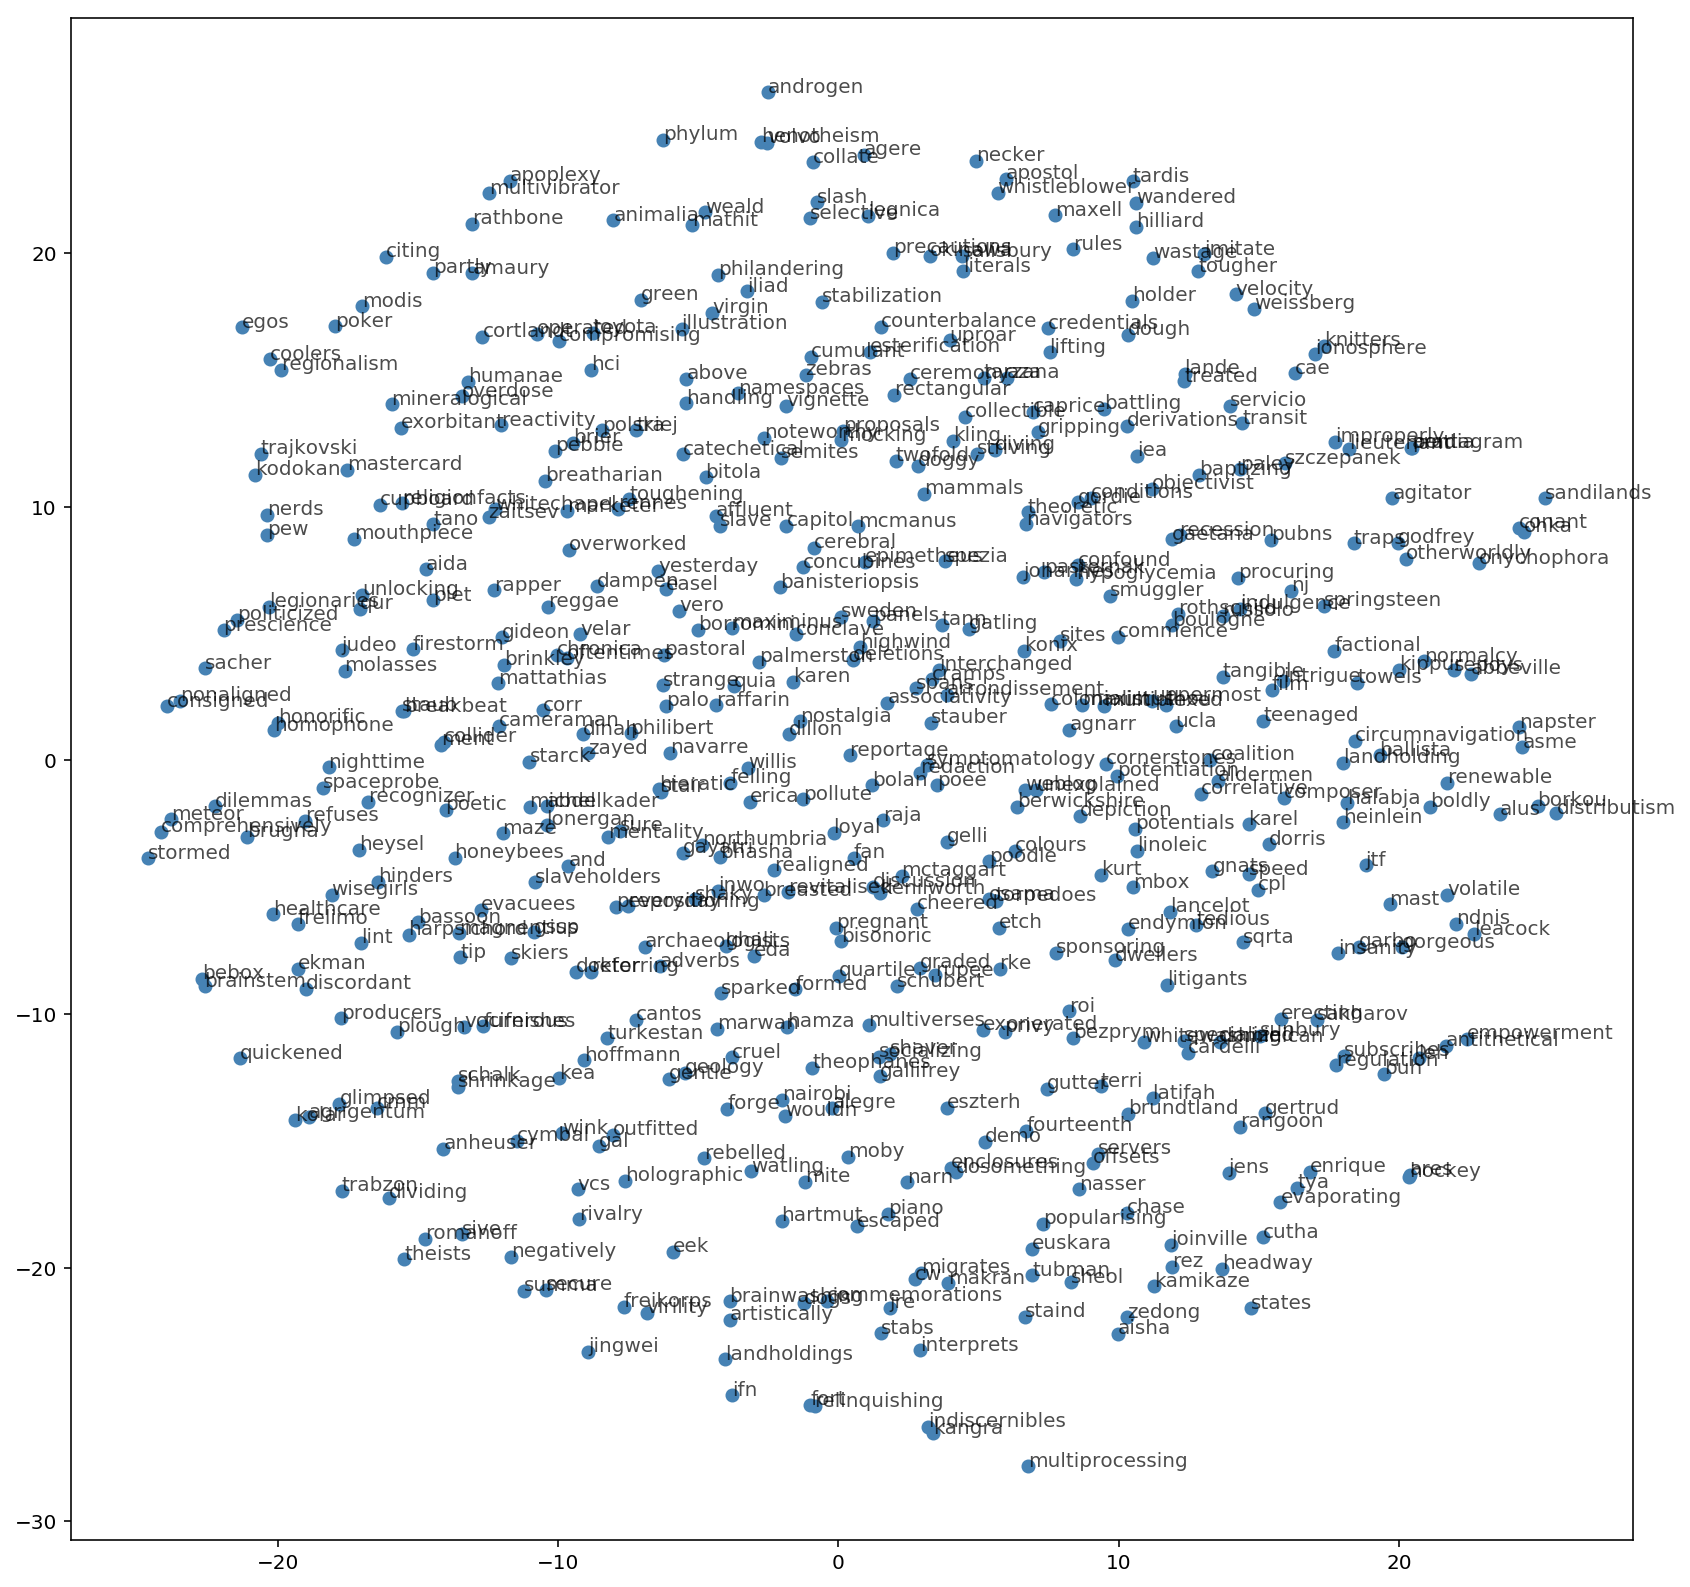

In [21]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)